##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Guided ES Demo

This is a fully self-contained notebook that reproduces the toy example in Fig.1 of the guided evolutionary strategies paper.

The main code is in the 'Algorithms' section below.

Contact: nirum@google.com

Date: 6/22/18

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow_probability version: {tfp.__version__}')

tensorflow version: 1.14.0
tensorflow_probability version: 0.7.0


## Helper functions

### Antithetic sampler

Creates custom getters for perturbing variables.

These are used to evaluate f(x + epsilon), where epsilon is some perturbation applied to the parameters, x.

This also stores the sampled noise (epsilon) in a dictionary, since we need to reuse the noise for the negative sample, when we want to compute f(x - epsilon). (note: this is where the name `antithetic` comes from)

In [5]:
class AntitheticSampler(object):
  def __init__(self, distributions):
    """Antithetic perturbations.
    
    Generates samples eta, and two custom getters that return
      (x + eta) and (x - eta)
    for a variable x.
    
    This is used to evaluate a loss at perturbed parameter values, e.g.:
    [f(x+eta), f(x-eta)]
    """
    
    # stores the sampled noise
    self.perturbations = {}
    
    # store the distributions
    self.distributions = distributions
  
  def pos_getter(self, getter, name, *args, **kwargs):
    """Custom getter for positive perturbation"""
    
    # get the variable
    variable = getter(name, *args, **kwargs)
    
    # check if we have pulled this variable before
    if name not in self.perturbations:
    
      # generate a noise sample and store it
      self.perturbations[name] = self.distributions[name].sample()

    # return the perturbed variable
    return variable + tf.reshape(self.perturbations[name], variable.shape)
 
  def neg_getter(self, getter, name, *args, **kwargs):
    """Custom getter for negative perturbation"""
    
    # get the variable
    variable = getter(name, *args, **kwargs)
    
    # check if we have pulled this variable before
    if name not in self.perturbations:
    
      # generate a noise sample and store it
      self.perturbations[name] = self.distributions[name].sample(shape=variable.shape)

    # return the perturbed variable
    return variable - tf.reshape(self.perturbations[name], variable.shape)

### Noise distributions

We draw perturbations of parameters from either a diagonal covariance (the standard evolutionary strategies algorithm), or from a diagonal plus low rank covariance (guided ES).

In [6]:
mvn_diag = tfp.distributions.MultivariateNormalDiag
mvn_lowrank = tfp.distributions.MultivariateNormalDiagPlusLowRank

## Algorithms

### Gradient descent

As a baseline, we will compare against running gradient descent directly on the biased gradients.

In [7]:
def gradient_descent(loss_fn, grads_and_vars):
  return grads_and_vars

### Evolutionary strategies

To compute descent directions using evolutionary strategies, we will use the antithetic sampler defined above.

This will let us perturb model parameters centered on the current iterate.

In [8]:
def evostrat_update(loss_fn, dists, grads_and_vars, beta, sigma):
  """Function to compute the evolutionary strategies.
  
  See the guided ES paper for details on the method.
  
  Args:
    loss_fn: function that builds the graph that computes the loss. loss_fn,
      when called, returns a scalar loss tensor.
    dists: dict mapping from variable names to distributions for perturbing
      those variables.
    grads_and_vars: list of (gradient, variable) tuples. The gradient and
      variable are tensors of the same shape. The gradient may be biased (it
      is not necessarily the gradient of the loss_fn).
    beta: float, scale hyperparameter of the guided ES algorithm.
    sigma: float, controls the overall std. dev. of the perturbation
      distribution.
     
   Returns:
    updates_and_vars: a list of (update, variable) tuples contaniing the
      estimated descent direction (update) and variable for each variable to
      optimize. (This list will be passed to a tf.train.Optimizer instance).
   """
  
  # build the antithetic sampler
  anti = AntitheticSampler(dists)
  
  # evaluate the loss at different parameters
  with tf.variable_scope('', custom_getter=anti.pos_getter):
    y_pos = loss_fn()
  
  with tf.variable_scope('', custom_getter=anti.neg_getter):
    y_neg = loss_fn()
    
  # use these losses to compute the evolutionary strategies update
  c = beta / (2 * sigma ** 2)
  updates_and_vars = [
      (c * tf.reshape(anti.perturbations[v.op.name], v.shape) * (y_pos - y_neg), v)
      for _, v in grads_and_vars]
  
  return updates_and_vars

### Vanilla ES

Vanilla ES is the standard evolutionary strategies algorithm. It uses a diagonal covariance matrix for perturbing parameters.

In [9]:
def vanilla_es(loss_fn, grads_and_vars, sigma=0.1, beta=1.0):
  
  def vardist(v):
    n = v.shape[0]
    scale_diag = (sigma / tf.sqrt(tf.cast(n, tf.float32))) * tf.ones(n)
    return mvn_diag(scale_diag=scale_diag)
  
  # build distributions
  dists = {v.op.name: vardist(v) for _, v in grads_and_vars}
  
  updates_and_vars = evostrat_update(loss_fn, dists, grads_and_vars, beta, sigma)
  
  return updates_and_vars

### Guided ES

Guided ES is our proposed method. It uses a diagonal plus low-rank covariance matrix for drawing perturbations, where the low-rank subspace is spanned by the available gradient information.

In [10]:
def guided_es(loss_fn, grads_and_vars, sigma=0.1, alpha=0.5, beta=1.0):
  
  def vardist(grad, variable):
    """Builds the sampling distribution for the given variable."""
    
    n = tf.cast(variable.shape[0], tf.float32)
    k = 1
    
    a = sigma * tf.sqrt(alpha / n)
    c = sigma * tf.sqrt((1-alpha) / k)
    b = tf.sqrt(a ** 2 + c ** 2) - a
    
    scale_diag = a * tf.ones(tf.cast(n, tf.int32))
    perturb_diag = b * tf.ones(1,)
    perturb_factor, _ = tf.qr(grad)
    
    return mvn_lowrank(scale_diag=scale_diag,
                       scale_perturb_factor=perturb_factor,
                       scale_perturb_diag=perturb_diag)
  
  dists = {v.op.name: vardist(g, v) for g, v in grads_and_vars}
  
  # antithetic getter
  updates_and_vars = evostrat_update(loss_fn, dists, grads_and_vars, beta, sigma)
  
  return updates_and_vars

## Tasks

### Perturbed quadratic

This is a toy problem where we explicitly add bias and variance to the gradient

In [11]:
def generate_problem(n, m, seed=None):
  rs = np.random.RandomState(seed=seed)
  
  # sample a random problem
  A = rs.randn(m, n)
  b = rs.randn(m, 1)
  
  grad_bias = rs.randn(n, 1)
  
  return A, b, grad_bias


def perturbed_quadratic(n, m, problem_seed):
  tf.reset_default_graph()
  
  # generate problem
  A_np, b_np, bias_np = generate_problem(n, m, seed=problem_seed)
  A = tf.convert_to_tensor(A_np, dtype=tf.float32)
  b = tf.convert_to_tensor(b_np, dtype=tf.float32)
  
  # sample gradient bias and noise
  grad_bias = 1.0 * tf.nn.l2_normalize(tf.convert_to_tensor(bias_np, dtype=tf.float32))
  grad_noise = 1.5 * tf.nn.l2_normalize(tf.random_normal(shape=(n, 1)))
    
  # compute loss
  def loss_fn():
    with tf.variable_scope('perturbed_quadratic', reuse=tf.AUTO_REUSE):
      x = tf.get_variable('x', shape=(n, 1), initializer=tf.zeros_initializer)
      
    resid = tf.matmul(A, x) - b
    return 0.5*tf.norm(resid)**2 / float(m)
    
  # compute perturbed gradient
  with tf.variable_scope('perturbed_quadratic', reuse=tf.AUTO_REUSE):
    x = tf.get_variable('x', shape=(n, 1), initializer=tf.zeros_initializer)
    
  err = tf.matmul(tf.transpose(A), tf.matmul(A, x) - b) / float(m)
  grad = err + (grad_bias + grad_noise) * tf.norm(err)
  grads_and_vars = [(grad, x)]
    
  return loss_fn, grads_and_vars

## Demo

### Vanilla ES

First, we run minimize the problem using vanilla evolutionary strategies.

In [12]:
tf.reset_default_graph()
loss_fn, gav = perturbed_quadratic(1000, 2000, 2)

updates = vanilla_es(loss_fn, gav, sigma=0.1, beta=1.0)

opt = tf.train.GradientDescentOptimizer(0.2)
train_op = opt.apply_gradients(updates)

loss = loss_fn()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
# train
fobj = []
for k in range(10000):
  f, _ = sess.run([loss, train_op])
  fobj.append(f)
  
# store results for plotting
ves = np.array(fobj).copy()

sess.close()

### Gradient descent

Our next baseline is gradient descent, applied directly to the biased gradients.

In [14]:
tf.reset_default_graph()
loss_fn, gav = perturbed_quadratic(1000, 2000, 2)

updates = gradient_descent(loss_fn, gav)

opt = tf.train.GradientDescentOptimizer(5e-3)
train_op = opt.apply_gradients(updates)

loss = loss_fn()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
# train
fobj = []
for k in range(10000):
  f, _ = sess.run([loss, train_op])
  fobj.append(f)

# store results for plotting
gd = np.array(fobj).copy()

sess.close()

### Guided ES

Finally, we will run the same problem using the guided evolutionary strategies method.

In [16]:
tf.reset_default_graph()
loss_fn, gav = perturbed_quadratic(1000, 2000, 2)

updates = guided_es(loss_fn, gav, sigma=0.1, alpha=0.5, beta=2.0)

opt = tf.train.GradientDescentOptimizer(0.2)
train_op = opt.apply_gradients(updates)
loss = loss_fn()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
# train
fobj = []
for k in range(10000):
  f, _ = sess.run([loss, train_op])
  fobj.append(f)
  
# store results for plotting
ges = np.array(fobj).copy()

sess.close()

### Plots

In [18]:
A, b, _ = generate_problem(1000, 2000, seed=2)
xstar = np.linalg.lstsq(A, b, rcond=None)[0]
f_opt = (0.5/2000) * np.linalg.norm(np.dot(A, xstar) - b) ** 2

As we see in the plot below, Guided ES combines the benefits of gradient descent (quick initial descent) and vanilla evolutionary strategies (converges on the true solution).

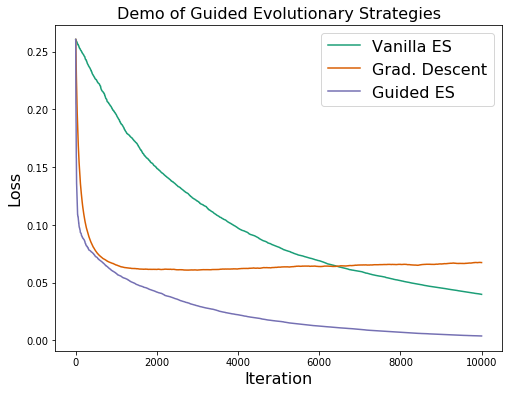

In [19]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(ves - f_opt, color=COLORS['ves'], label='Vanilla ES')
plt.plot(gd - f_opt, color=COLORS['sgdm'], label='Grad. Descent')
plt.plot(ges - f_opt, color=COLORS['ges'], label='Guided ES')
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Demo of Guided Evolutionary Strategies', fontsize=16);